# Phenology of recurrent and persistent fractions

Following Donohue 2009 and Henriques 2024

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023JG007993

In [1]:
import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import scipy.signal
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.geom import Geometry
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import _extract_peaks_troughs, xr_phenometrics

Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead


In [2]:
# # Savitsky-Golay smoothing function
def sg_smooth(ds, window, poly, deriv):
    return xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=window,
            polyorder=poly,
            deriv=deriv,
            mode='interp'),
        dask='parallelized'
    )

In [35]:
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
gdf = gpd.read_file(ecoregions_file)

In [ ]:
k = 'Weipa Plateau'

In [47]:
# ds = assign_crs(xr.open_dataset('/g/data1a/os22/chad_tmp/Aus_phenology/data/trees_fraction.nc'), crs='epsg:4326')['trees']
ds = assign_crs(xr.open_dataset('/g/data1a/os22/chad_tmp/Aus_phenology/data/grass_fraction.nc'), crs='epsg:4326')['grass']

#bare soil NDVI data
ss_path = f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_5km.nc'
ss = assign_crs(xr.open_dataarray(ss_path), crs='epsg:4326')
ss.name = 'NDVI'

In [48]:
#bare soil NDVI clip to region
geom = Geometry(geom=gdf[gdf['SUB_NAME_7'] == k].geometry.item(), crs=gdf.crs)
soil = ss.odc.mask(poly=geom)
soil = soil.mean().values.item()

ds = ds.odc.mask(poly=geom)

ds = ds.mean(['latitude', 'longitude'])
ds = ds.resample(time="2W").interpolate("linear")
ds = sg_smooth(ds,window=11, poly=3, deriv=0)
ds =ds.dropna(dim='time',how='all').resample(time='1D').interpolate(kind='quadratic')

ds = ds.expand_dims(latitude=[-33.0],longitude=[135.0])
ds

<xarray.DataArray 'grass' (latitude: 1, longitude: 1, time: 14869)> Size: 119kB
array([[[-0.00061594,  0.00067236,  0.00193283, ...,  0.00343777,
          0.00338752,  0.00337996]]])
Coordinates:
  * latitude     (latitude) float64 8B -33.0
  * longitude    (longitude) float64 8B 135.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 119kB 1982-01-17 ... 2022-10-02

In [49]:
#apply pheno
p = xr_phenometrics(ds,
                rolling=90,
                distance=90,
                prominence='auto',
                plateau_size=10,
                amplitude=0.2,
                verbose=True,
                soil_signal=soil,
                   ).compute()

p = p.squeeze().drop_vars(['latitude','longitude']).to_dataframe()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


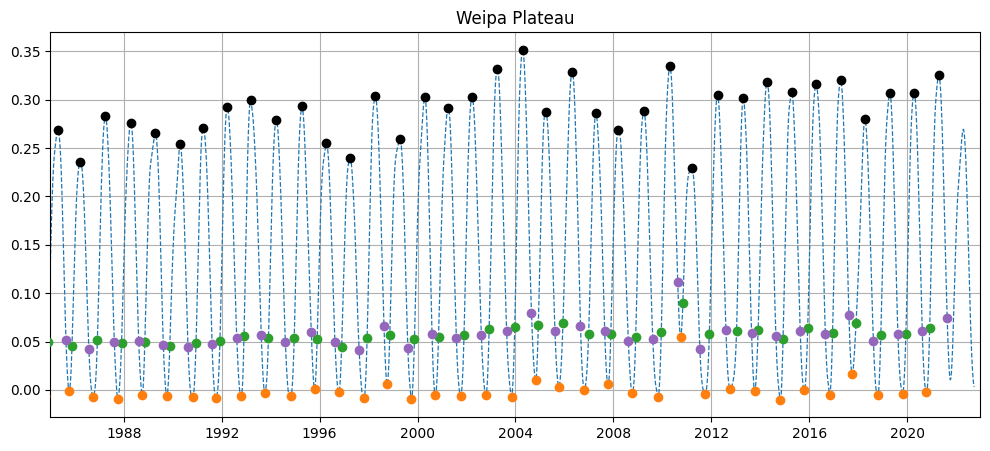

In [50]:
fig,ax = plt.subplots(1,1, figsize=(12,5))

ds.plot(ax=ax, color='tab:blue', linestyle='--', linewidth=0.9, label='Daily NDVI') #.sel(time=slice('1997','2016'))
# ax.set_ylim(0.25,0.5)
ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(p.SOS.values, p.SOS_year.values)],
           y=p.vSOS,
          c='tab:green', label='SOS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(p.EOS.values, p.EOS_year.values)],
           y=p.vEOS,
          c='tab:purple', label='EOS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(p.POS.values, p.POS_year.values)],
               y=p.vPOS,
              c='black', label='POS', zorder=10)
    
ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(p.TOS.values, p.TOS_year.values)],
           y=p.vTOS,
          c='tab:orange', label='TOS', zorder=10)

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title(k, fontsize=12)
ax.grid()
ax.set_yticklabels(['{:2.2f}'.format(x) for x in ax.get_yticks()]);
ax.set_xlim(pd.Timestamp("1985-01-1"), pd.Timestamp("2022-12-31"));